<H3> Data science approach to open new restaurant in the city of Raleigh (Wake County). <H3>

<H3>INTRODUCTION<H3>
<H4>Raleigh-Durham twin cities region also known as the RTP (Research Triangle Park) is one of the fastest growing regions of the US which is also a technology and research hub for fortune 500 corporation. There is a huge influx and growth in population as well as a big surge in the airport traffic which indicates the amount of growth experienced by this region. The travel data for the airport traffic with Passenger volume at RDU hit an all-time high in June, with more than 679,000 travelers boarding flights throughout the month – a 10.6 percent increase over June 2018.<H4>

### BUSINESS CASE

##### One of our clients which run a big restaurant chain has approached us to provide them an analysis and recommendation to open a set of new restaurants chain across the wake county to serve the growing needs of the region and help them identify the best locations for launching the new restaurant outlets.

###### The following criteria are considered by the client to choose the location of the new restaurant:
1.	Uniqueness – This criterion checks for the availability of similar restaurant in the vicinity, we were advised to identify locations which does not have the same chain restaurants within 2 Kilometer Radius.
2.	Visibility and accessibility. Select a spot that can be seen by those driving or walking by. You should also look for an area that gets plenty of passersby on foot or in cars. In addition, consider if there is parking and ease of access by foot or car.
3.	The demographics. Ensure the target market of your restaurant matches the demographics of the area.
4.	Labor costs and minimum wage. It’s important to ensure that the labor costs of an area don’t cut into your profits. You will also want to have an idea of what employees might expect to make based on the location.
5.	The competition of the area. Some nearby competition can help with marketing. But it’s wise to have enough of a distance that you can still guarantee a solid pool of customers who won’t be easily drawn to another similar place.

### DATA SOURCE
#### In this capstone project we will address the Uniqueness requirement of the client and use the latest updated source data available in the Raleigh – Open Data portal [http://data-ral.opendata.arcgis.com/] related to existing restaurants in the wake county and provide an analysis and recommendation to identify new restaurant locations in the wake county geography using the modern data science approach and foursquare APIs.
#### The following data source is also used to initially study the feasibility of opening the restaurant in the wake county based on the floating population that comes into the city by way of airtraffic.
##### Here is the sample data source captured from the RDU airport authority - https://www.rdu.com/airport-authority/statistics/

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')





Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

#### Load and explore the data

In [2]:
# The code was removed by Watson Studio for sharing.

,YEAR,Departures,Arrivals,Total
29,1989,4318325,4276346,8594671
28,1990,4650872,4614793,9265665
27,1991,4698543,4683043,9381586
26,1992,4977071,4948293,9925364
25,1993,4862285,4833601,9695886


Text(0, 0.5, 'Total Arrivals and Departures (in Millions)')

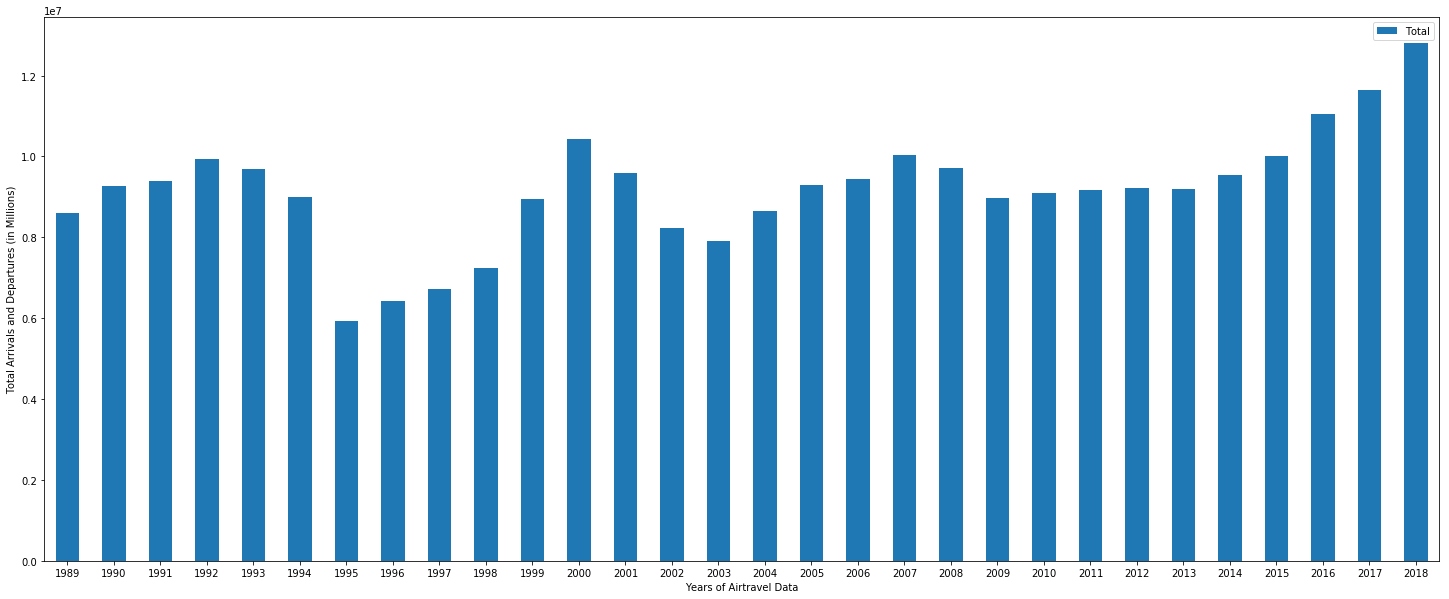

In [3]:
#dfToList = df['one'].tolist()
Total = trafficData['Total'].tolist()
#Arrivals =df['Arrivals'].tolist()
years =  trafficData['YEAR'].tolist()
df = pd.DataFrame({'YEARS':years, 'Total': Total})
ax = df.plot.bar(x='YEARS', y='Total', rot=0,  figsize=(25, 10))
# Set the label for the x-axis
ax.set_xlabel("Years of Airtravel Data")

# Set the label for the y-axis
ax.set_ylabel("Total Arrivals and Departures (in Millions)")


###### Let us look at the restaurant data available for wake county

In [4]:

body = client_4799fcf3316b4a629dd211f84d87c049.get_object(Bucket='datasciencecapstoneproject-donotdelete-pr-ub6a0y1hflomlx',Key='Restaurants_in_Wake_County.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_0 = pd.read_excel(body)
df_data_0.head()
df_data_0.shape
print('RALEIGH RESTAURANT LIST dataframe created.')


RALEIGH RESTAURANT LIST dataframe created.


In [5]:
df = df_data_0.dropna(subset=["LATITUDE"], axis=0)

In [6]:
print(df.columns)
restData = df.drop(['X', 'Y', 'OBJECTID','ADDRESS', 'BUSINESS_ID', 'PHONE_NUMBER'], axis=1)
restData.head()

Index(['X', 'Y', 'OBJECTID', 'BUSINESS_ID', 'NAME', 'ADDRESS', 'CITY', 'STATE',
       'POSTAL_CODE', 'LATITUDE', 'LONGITUDE', 'PHONE_NUMBER'],
      dtype='object')


,NAME,CITY,STATE,POSTAL_CODE,LATITUDE,LONGITUDE
0,MCDONALDS #13824,GARNER,NC,27529.0,35.685632,-78.604503
1,CHAR-GRILL OF GARNER,GARNER,NC,27529.0,35.689060,-78.577039
2,Chick-Fil-A #01488,GARNER,NC,27529.0,35.692121,-78.582617
3,BUFFALO BROTHERS GARNER,GARNER,NC,27529.0,35.687894,-78.580738
4,FAMOUS TOASTERY,GARNER,NC,27529.0,35.697230,-78.585250


In [7]:
restData=restData.dropna()
restData.shape


(2881, 6)

In [8]:
print('The dataframe has {} Cities and {} Restaurants.'.format(
        len(restData['CITY'].unique()),
        restData.shape[0]
    )
)
restData.head()
restData["NAME"].fillna("No DATA", inplace = True)  
restData.replace(to_replace = np.nan, value = -99) 
restData.head()
restData=restData.drop(restData.index[2000:2010])
print('The dataframe has {} Cities and {} Restaurants.'.format(
        len(restData['CITY'].unique()),
        restData.shape[0]
    )
)

The dataframe has 36 Cities and 2881 Restaurants.
The dataframe has 36 Cities and 2871 Restaurants.


#### Our client is Mc Donanld's corporation who are looking to open new outlets in the wake county region by performing the data analysis on the existing locations and then identify the suitable locations for the new outlets based on the uniqueness and location demographics.

In [9]:
# we will filter the restaurent data to a data frame that will have a list of all Mc Ds in the wake county region.
topRest=restData
#chipotle_data = restData[restData['NAME'].str.contains("MCDONALDS")].reset_index(drop=True)
macd_data = topRest[topRest['NAME'].str.contains("MCDONALD")].reset_index(drop=True)
print(macd_data.shape)
macd_data.head(20)


(48, 6)


,NAME,CITY,STATE,POSTAL_CODE,LATITUDE,LONGITUDE
0,MCDONALDS #13824,GARNER,NC,27529.0,35.685632,-78.604503
1,MCDONALDS #32242,HOLLY SPRINGS,NC,27540.0,35.636251,-78.831080
2,MCDONALD'S #32242,HOLLY SPRINGS,NC,27540.0,35.636251,-78.831080
3,MCDONALDS #32242,HOLLY SPRINGS,NC,27540.0,35.636251,-78.831080
4,MCDONALD'S #11646,KNIGHTDALE,NC,27545.0,35.798777,-78.488555
5,MCDONALDS AT WALMART MORRISVILLE (31892),MORRISVILLE,NC,27560.0,35.866591,-78.846933
6,MCDONALDS #32336,MORRISVILLE,NC,27560.0,35.818898,-78.844822
7,MCDONALDS #31892 MORRISVILLE WALMART,MORRISVILLE,NC,27560.0,35.866591,-78.846933
8,MCDONALDS #4311,MORRISVILLE,NC,27560.0,35.818898,-78.844822
9,MCDONALDS #32336,MORRISVILLE,NC,27560.0,35.818898,-78.844822


In [10]:
address = 'Wake County, NC'

geolocator = Nominatim(user_agent="raleigh_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of wake County are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of wake County are 35.7979355, -78.6118311.


In [11]:
# create map of New York using latitude and longitude values
map_macd_wake = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, CITY, NAME in zip(macd_data['LATITUDE'], macd_data['LONGITUDE'], macd_data['CITY'], macd_data['NAME']):
    label = '{}, {}'.format(NAME, CITY)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_macd_wake)  
    
#map_macd_wake

#### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
#### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'B1I5EPK4F3MH5DTENEUGJPYEZDUBOTROUDEAEMEWJG1FPMN2' # your Foursquare ID
CLIENT_SECRET = 'GXNYK3RZ4W2LPWSN2MEJLZZWY5OGUCIL0KWGUDQCT1AV45G0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B1I5EPK4F3MH5DTENEUGJPYEZDUBOTROUDEAEMEWJG1FPMN2
CLIENT_SECRET:GXNYK3RZ4W2LPWSN2MEJLZZWY5OGUCIL0KWGUDQCT1AV45G0


#### Let's explore the first city where the Mac D is located in our dataframe.


In [13]:
macd_data.loc[0, 'CITY']

'GARNER'

In [14]:
neighborhood_latitude = macd_data.loc[0, 'LATITUDE'] # neighborhood latitude value
neighborhood_longitude = macd_data.loc[0, 'LONGITUDE'] # neighborhood longitude value
neighborhood_name = macd_data.loc[0, 'CITY'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of GARNER are 35.68563177, -78.60450265.


#### Now, let's get the top 100 venues that are in GARNER within a radius of 500 meters.
First, let's create the GET request URL. Name your URL **url**.

In [15]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
print(url)

https://api.foursquare.com/v2/venues/explore?&client_id=B1I5EPK4F3MH5DTENEUGJPYEZDUBOTROUDEAEMEWJG1FPMN2&client_secret=GXNYK3RZ4W2LPWSN2MEJLZZWY5OGUCIL0KWGUDQCT1AV45G0&v=20180605&ll=35.68563177,-78.60450265&radius=500&limit=100


In [16]:
results = requests.get(url).json()
#results

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Alexander's Mediterranean Cuisine,Mediterranean Restaurant,35.685264,-78.606419
1,Food Lion Grocery Store,Supermarket,35.685068,-78.605398
2,Subway,Sandwich Place,35.684936,-78.606211
3,McDonald's,Fast Food Restaurant,35.685676,-78.604440
4,Burger King,Fast Food Restaurant,35.684371,-78.604328


In [19]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

11 venues were returned by Foursquare.


### 2. Explore cities with existing Mac Donalds, so that we can identify where we can open a new outlet.

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:

macd_venues = getNearbyVenues(names=macd_data['CITY'],
                                   latitudes=macd_data['LATITUDE'],
                                   longitudes=macd_data['LONGITUDE']
                                  )

GARNER
HOLLY SPRINGS
HOLLY SPRINGS
HOLLY SPRINGS
KNIGHTDALE
MORRISVILLE
MORRISVILLE
MORRISVILLE
MORRISVILLE
MORRISVILLE
CARY
CARY
CARY
CARY
CARY
CARY
CARY
CARY
CARY
CARY
CARY
FUQUAY VARINA
FUQUAY-VARINA
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
Rolesville
WAKE FOREST
WENDELL
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH
RALEIGH


In [22]:
print(macd_venues.shape)
macd_venues.head()

(1197, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,GARNER,35.685632,-78.604503,Alexander's Mediterranean Cuisine,35.685264,-78.606419,Mediterranean Restaurant
1,GARNER,35.685632,-78.604503,Food Lion Grocery Store,35.685068,-78.605398,Supermarket
2,GARNER,35.685632,-78.604503,Subway,35.684936,-78.606211,Sandwich Place
3,GARNER,35.685632,-78.604503,McDonald's,35.685676,-78.604440,Fast Food Restaurant
4,GARNER,35.685632,-78.604503,Burger King,35.684371,-78.604328,Fast Food Restaurant


In [23]:
macd_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
CARY,275,275,275,275,275,275
FUQUAY-VARINA,33,33,33,33,33,33
GARNER,11,11,11,11,11,11
HOLLY SPRINGS,63,63,63,63,63,63
KNIGHTDALE,23,23,23,23,23,23
MORRISVILLE,135,135,135,135,135,135
RALEIGH,611,611,611,611,611,611
Rolesville,17,17,17,17,17,17
WAKE FOREST,20,20,20,20,20,20


In [24]:
print('There are {} uniques categories.'.format(len(macd_venues['Venue Category'].unique())))

There are 144 uniques categories.


### 3. Analyze Each Neighborhood

In [25]:
macd_onehot = pd.get_dummies(macd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
macd_onehot['Neighborhood'] = macd_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [macd_onehot.columns[-1]] + list(macd_onehot.columns[:-1])
macd_onehot = macd_onehot[fixed_columns]

macd_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Garden,Beer Store,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Burger Joint,Butcher,Café,Camera Store,Candy Store,Carpet Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Classroom,Convenience Store,Cosmetics Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Disc Golf,Discount Store,Dive Bar,Donut Shop,Dry Cleaner,Electronics Store,Eye Doctor,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Latin American Restaurant,Lawyer,Liquor Store,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Music School,Nail Salon,Nightclub,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tex-Mex Restaurant,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,GARNER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,GARNER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GARNER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,GARNER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,GARNER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
macd_onehot.shape

(1197, 145)

In [27]:
#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [54]:
macd_grouped = macd_onehot.groupby('Neighborhood').mean().reset_index()
macd_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Garden,Beer Store,Big Box Store,Bistro,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Burger Joint,Butcher,Café,Camera Store,Candy Store,Carpet Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Classroom,Convenience Store,Cosmetics Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Disc Golf,Discount Store,Dive Bar,Donut Shop,Dry Cleaner,Electronics Store,Eye Doctor,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Latin American Restaurant,Lawyer,Liquor Store,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Music School,Nail Salon,Nightclub,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Pub,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tex-Mex Restaurant,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,CARY,0.007273,0.029091,0.0,0.007273,0.007273,0.010909,0.000000,0.0,0.000000,0.007273,0.021818,0.007273,0.0,0.007273,0.0,0.0,0.000000,0.007273,0.0,0.0,0.0,0.007273,0.0,0.007273,0.000000,0.007273,0.007273,0.0,0.007273,0.0,0.025455,0.014545,0.0,0.040000,0.0,0.000000,0.007273,0.007273,0.0,0.0,0.007273,0.0,0.0,0.0,0.007273,0.0,0.025455,0.007273,0.007273,0.0,0.029091,0.0,0.007273,0.0,0.0,0.000000,0.007273,0.014545,0.000000,0.0,0.014545,0.007273,0.0,0.021818,0.014545,0.021818,0.0,0.0,0.0,0.018182,0.0,0.000000,0.007273,0.0,0.021818,0.0,0.014545,0.0,0.014545,0.0,0.0,0.0,0.007273,0.007273,0.007273,0.0,0.0,0.021818,0.0,0.040000,0.0,0.014545,0.0,0.0,0.007273,0.0,0.007273,0.018182,0.007273,0.0,0.0,0.007273,0.036364,0.054545,0.0,0.0,0.007273,0.0,0.007273,0.0,0.007273,0.014545,0.054545,0.014545,0.007273,0.000000,0.007273,0.014545,0.0,0.000000,0.0,0.014545,0.007273,0.007273,0.0,0.007273,0.025455,0.000000,0.007273,0.0,0.0,0.0,0.0,0.007273,0.007273,0.0,0.000000,0.018182,0.0,0.0,0.0,0.014545,0.0,0.0
1,FUQUAY-VARINA,0.000000,0.030303,0.0,0.030303,0.030303,0.000000,0.000000,0.0,0.030303,0.000000,0.000000,0.030303,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.030303,0.0,0.000000,0.030303,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.030303,0.0,0.000000,0.000000,0.030303,0.0,0.0,0.000000,0.0,0.0,0.0,0.030303,0.0,0.030303,0.000000,0.000000,0.0,0.181818,0.0,0.000000,0.0,0.0,0.030303,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.030303,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.090909,0.0,0.030303,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.030303,0.090909,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.090909,0.030303,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0

In [29]:
macd_grouped.shape

(10, 145)

#### Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in macd_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = macd_grouped[macd_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CARY----
                venue  freq
0         Pizza Place  0.05
1      Sandwich Place  0.05
2  Mexican Restaurant  0.04
3         Coffee Shop  0.04
4            Pharmacy  0.04


----FUQUAY-VARINA----
                  venue  freq
0  Fast Food Restaurant  0.18
1           Supermarket  0.09
2    Mexican Restaurant  0.09
3           Pizza Place  0.09
4        Ice Cream Shop  0.03


----GARNER----
                      venue  freq
0      Fast Food Restaurant  0.18
1             Shopping Mall  0.09
2  Mediterranean Restaurant  0.09
3              Burger Joint  0.09
4               Supermarket  0.09


----HOLLY SPRINGS----
                  venue  freq
0  Fast Food Restaurant  0.14
1     Mobile Phone Shop  0.05
2                   Gym  0.05
3           Pizza Place  0.05
4        Sandwich Place  0.05


----KNIGHTDALE----
                  venue  freq
0           Pizza Place  0.13
1   Fried Chicken Joint  0.09
2         Big Box Store  0.09
3        Sandwich Place  0.09
4  Fast Food Restau

#### Let's put that into a *pandas* dataframe and sort the venues in decending order

In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = macd_grouped['Neighborhood']

for ind in np.arange(macd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(macd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CARY,Sandwich Place,Pizza Place,Coffee Shop,Mexican Restaurant,Pharmacy,American Restaurant,Fast Food Restaurant,Donut Shop,Supermarket,Chinese Restaurant
1,FUQUAY-VARINA,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Supermarket,Coffee Shop,Supplement Shop,Pharmacy,Discount Store,Mobile Phone Shop,Donut Shop
2,GARNER,Fast Food Restaurant,Japanese Restaurant,Pizza Place,Supermarket,Shopping Mall,Burger Joint,Breakfast Spot,Sandwich Place,Mediterranean Restaurant,Gaming Cafe
3,HOLLY SPRINGS,Fast Food Restaurant,Gym,Shop & Service,Breakfast Spot,Smoke Shop,Shoe Store,Shipping Store,Donut Shop,Big Box Store,Beer Store
4,KNIGHTDALE,Pizza Place,Big Box Store,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Pharmacy,Discount Store,Seafood Restaurant,Burger Joint,Breakfast Spot
5,MORRISVILLE,Pharmacy,Grocery Store,Pizza Place,Video Store,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Bagel Shop,Medical Center,Japanese Curry Restaurant
6,RALEIGH,Fast Food Restaurant,Mexican Restaurant,Furniture / Home Store,Pizza Place,American Restaurant,Sandwich Place,Bar,Hotel,Coffee Shop,Chinese Restaurant
7,Rolesville,Fast Food Restaurant,Pizza Place,Coffee Shop,Mexican Restaurant,Discount Store,Pharmacy,Beer Store,Supermarket,Seafood Restaurant,Baseball Field
8,WAKE FOREST,Pizza Place,Coffee Shop,Bank,Pharmacy,Chinese Restaurant,Salon / Barbershop,Mexican Restaurant,Shipping Store,Mediterranean Restaurant,Bistro
9,WENDELL,Convenience Store,Grocery Store,Food,Supermarket,Discount Store,Sandwich Place,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Dance Studio


###  Cluster Neighborhoods

In [123]:
# Run k-means to cluster the neighborhood into 5 clusters.
# set number of clusters
kclusters = 5

macd_grouped_clustering = macd_grouped.drop('Neighborhood', 1)
#print(macd_grouped_clustering)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(macd_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 



array([1, 3, 0, 3, 4, 1, 1, 3, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [124]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head(10)
macd_merged = macd_data.drop_duplicates(['CITY'], keep='first')
macd_merged.sort_values(['CITY'], ascending=True, inplace=True)
macd_merged = macd_merged[macd_merged.CITY != 'FUQUAY-VARINA'].reset_index(drop=True)
macd_merged = macd_merged.drop(['NAME', 'STATE', 'POSTAL_CODE'], axis=1)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [116]:
# merge macd_grouped with macd_data to add latitude/longitude for each CITY
macd_merged = macd_merged.join(neighborhoods_venues_sorted)
# macd_merged = macd_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='CITY')
macd_merged.head(20) 
# check the last columns!

,CITY,LATITUDE,LONGITUDE,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CARY,35.759028,-78.743340,1,CARY,Sandwich Place,Pizza Place,Coffee Shop,Mexican Restaurant,Pharmacy,American Restaurant,Fast Food Restaurant,Donut Shop,Supermarket,Chinese Restaurant
1,FUQUAY VARINA,35.562317,-78.806088,3,FUQUAY-VARINA,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Supermarket,Coffee Shop,Supplement Shop,Pharmacy,Discount Store,Mobile Phone Shop,Donut Shop
2,GARNER,35.685632,-78.604503,0,GARNER,Fast Food Restaurant,Japanese Restaurant,Pizza Place,Supermarket,Shopping Mall,Burger Joint,Breakfast Spot,Sandwich Place,Mediterranean Restaurant,Gaming Cafe
3,HOLLY SPRINGS,35.636251,-78.831080,3,HOLLY SPRINGS,Fast Food Restaurant,Gym,Shop & Service,Breakfast Spot,Smoke Shop,Shoe Store,Shipping Store,Donut Shop,Big Box Store,Beer Store
4,KNIGHTDALE,35.798777,-78.488555,4,KNIGHTDALE,Pizza Place,Big Box Store,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Pharmacy,Discount Store,Seafood Restaurant,Burger Joint,Breakfast Spot
5,MORRISVILLE,35.866591,-78.846933,1,MORRISVILLE,Pharmacy,Grocery Store,Pizza Place,Video Store,Fast Food Restaurant,Sandwich Place,Mexican Restaurant,Bagel Shop,Medical Center,Japanese Curry Restaurant
6,RALEIGH,35.906400,-78.601343,1,RALEIGH,Fast Food Restaurant,Mexican Restaurant,Furniture / Home Store,Pizza Place,American Restaurant,Sandwich Place,Bar,Hotel,Coffee Shop,Chinese Restaurant
7,Rolesville,35.917010,-78.467015,3,Rolesville,Fast Food Restaurant,Pizza Place,Coffee Shop,Mexican Restaurant,Discount Store,Pharmacy,Beer Store,Supermarket,Seafood Restaurant,Baseball Field
8,WAKE FOREST,35.944909,-78.506228,1,WAKE FOREST,Pizza Place,Coffee Shop,Bank,Pharmacy,Chinese Restaurant,Salon / Barbershop,Mexican Restaurant,Shipping Store,Mediterranean Restaurant,Bistro
9,WENDELL,35.792300,-78.379672,2,WENDELL,Convenience Store,Grocery Store,Food,Supermarket,Discount Store,Sandwich Place,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Dance Studio


Finally, let's visualize the resulting clusters

In [118]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(macd_merged['LATITUDE'], macd_merged['LONGITUDE'], macd_merged['CITY'], macd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###  Examine Clusters
#### Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster.

In [122]:
## CLUSTER 1
macd_merged.loc[macd_merged['Cluster Labels'] == 0, macd_merged.columns[[1] + list(range(5, macd_merged.shape[1]))]]

In [ ]:
## CLUSTER 2
macd_merged.loc[macd_merged['Cluster Labels'] == 1, macd_merged.columns[[1] + list(range(5, macd_merged.shape[1]))]]

In [ ]:

## CLUSTER 3
macd_merged.loc[macd_merged['Cluster Labels'] == 2, macd_merged.columns[[1] + list(range(5, macd_merged.shape[1]))]]

In [ ]:
## CLUSTER 4
macd_merged.loc[macd_merged['Cluster Labels'] == 3, macd_merged.columns[[1] + list(range(5, macd_merged.shape[1]))]]

In [ ]:
## CLUSTER 5
macd_merged.loc[macd_merged['Cluster Labels'] == 4, macd_merged.columns[[1] + list(range(5, macd_merged.shape[1]))]]